In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [33]:
df = pd.read_csv('/content/train.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,01-01-2011 00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,01-01-2011 01:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,01-01-2011 02:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,01-01-2011 03:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,01-01-2011 04:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [34]:
df.shape

(10886, 12)

In [35]:
df = df.drop(['holiday', 'workingday','atemp'], axis=1)


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   weather     10886 non-null  int64  
 3   temp        10886 non-null  float64
 4   humidity    10886 non-null  int64  
 5   windspeed   10886 non-null  float64
 6   casual      10886 non-null  int64  
 7   registered  10886 non-null  int64  
 8   count       10886 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 765.5+ KB


In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000
count,10886.0,191.574132,181.144454,1.00,42.0000,145.000,284.0000,977.0000


**Feature Engineering**


There are times when multiple features are provided in the same feature or we have to derive some features from the existing ones. We will also try to include some extra features in our dataset so, that we can derive some interesting insights from the data we have. Also if the features derived are meaningful then they become a deciding factor in increasing the model’s accuracy significantly.

In [38]:
parts = df['datetime'].str.split(" ", n = 2, expand = True)
df['date'] = parts[0]
df['time'] = parts[1].str[:2].astype('int')
df.head()

,datetime,season,weather,temp,humidity,windspeed,casual,registered,count,date,time
0,01-01-2011 00:00,1,1,9.84,81,0.0,3,13,16,01-01-2011,0
1,01-01-2011 01:00,1,1,9.02,80,0.0,8,32,40,01-01-2011,1
2,01-01-2011 02:00,1,1,9.02,80,0.0,5,27,32,01-01-2011,2
3,01-01-2011 03:00,1,1,9.84,75,0.0,3,10,13,01-01-2011,3
4,01-01-2011 04:00,1,1,9.84,75,0.0,0,1,1,01-01-2011,4


In the above step, we have separated the date and time. Now let’s extract the day, month, and year from the date column.

In [39]:
parts = df['date'].str.split("-", n = 3, expand = True)
df['day'] = parts[0].astype('int')
df['month'] = parts[1].astype('int')
df['year'] = parts[2].astype('int')
df.head()

,datetime,season,weather,temp,humidity,windspeed,casual,registered,count,date,time,day,month,year
0,01-01-2011 00:00,1,1,9.84,81,0.0,3,13,16,01-01-2011,0,1,1,2011
1,01-01-2011 01:00,1,1,9.02,80,0.0,8,32,40,01-01-2011,1,1,1,2011
2,01-01-2011 02:00,1,1,9.02,80,0.0,5,27,32,01-01-2011,2,1,1,2011
3,01-01-2011 03:00,1,1,9.84,75,0.0,3,10,13,01-01-2011,3,1,1,2011
4,01-01-2011 04:00,1,1,9.84,75,0.0,0,1,1,01-01-2011,4,1,1,2011


Whether it is a weekend or a weekday must have some effect on the ride request count.

In [40]:
from datetime import datetime

def weekend_or_weekday(year, month, day):
  d = datetime(year, month, day)
  if d.weekday() > 4:
    return 0
  else:
    return 1

df['weekday'] = df.apply(lambda x: weekend_or_weekday(x['year'],
                                                      x['month'],
                                                      x['day']), axis = 1)

df.head()


,datetime,season,weather,temp,humidity,windspeed,casual,registered,count,date,time,day,month,year,weekday
0,01-01-2011 00:00,1,1,9.84,81,0.0,3,13,16,01-01-2011,0,1,1,2011,0
1,01-01-2011 01:00,1,1,9.02,80,0.0,8,32,40,01-01-2011,1,1,1,2011,0
2,01-01-2011 02:00,1,1,9.02,80,0.0,5,27,32,01-01-2011,2,1,1,2011,0
3,01-01-2011 03:00,1,1,9.84,75,0.0,3,10,13,01-01-2011,3,1,1,2011,0
4,01-01-2011 04:00,1,1,9.84,75,0.0,0,1,1,01-01-2011,4,1,1,2011,0


Bike ride demands are also affected by whether it is am or pm.

In [41]:
def am_or_pm(x):
  if x > 11:
    return 1
  else:
    return 0

df['am_or_pm'] = df['time'].apply(am_or_pm)
df.head()

,datetime,season,weather,temp,humidity,windspeed,casual,registered,count,date,time,day,month,year,weekday,am_or_pm
0,01-01-2011 00:00,1,1,9.84,81,0.0,3,13,16,01-01-2011,0,1,1,2011,0,0
1,01-01-2011 01:00,1,1,9.02,80,0.0,8,32,40,01-01-2011,1,1,1,2011,0,0
2,01-01-2011 02:00,1,1,9.02,80,0.0,5,27,32,01-01-2011,2,1,1,2011,0,0
3,01-01-2011 03:00,1,1,9.84,75,0.0,3,10,13,01-01-2011,3,1,1,2011,0,0
4,01-01-2011 04:00,1,1,9.84,75,0.0,0,1,1,01-01-2011,4,1,1,2011,0,0


It would be nice to have a column which can indicate whether there was any holiday on a particular day or not.

In [42]:
from datetime import datetime
import holidays

def is_holiday(x):
  india_holidays = holidays.country_holidays('IN')

  if india_holidays.get(x):
    return 1
  else:
    return 0

df['holidays'] = df['date'].apply(is_holiday)
df.head()

,datetime,season,weather,temp,humidity,windspeed,casual,registered,count,date,time,day,month,year,weekday,am_or_pm,holidays
0,01-01-2011 00:00,1,1,9.84,81,0.0,3,13,16,01-01-2011,0,1,1,2011,0,0,0
1,01-01-2011 01:00,1,1,9.02,80,0.0,8,32,40,01-01-2011,1,1,1,2011,0,0,0
2,01-01-2011 02:00,1,1,9.02,80,0.0,5,27,32,01-01-2011,2,1,1,2011,0,0,0
3,01-01-2011 03:00,1,1,9.84,75,0.0,3,10,13,01-01-2011,3,1,1,2011,0,0,0
4,01-01-2011 04:00,1,1,9.84,75,0.0,0,1,1,01-01-2011,4,1,1,2011,0,0,0


Now let’s remove the columns which are not useful for us.



In [43]:
df.drop(['datetime', 'date'],axis = 1, inplace = True)

In [44]:
df

,season,weather,temp,humidity,windspeed,casual,registered,count,time,day,month,year,weekday,am_or_pm,holidays
0,1,1,9.84,81,0.0000,3,13,16,0,1,1,2011,0,0,0
1,1,1,9.02,80,0.0000,8,32,40,1,1,1,2011,0,0,0
2,1,1,9.02,80,0.0000,5,27,32,2,1,1,2011,0,0,0
3,1,1,9.84,75,0.0000,3,10,13,3,1,1,2011,0,0,0
4,1,1,9.84,75,0.0000,0,1,1,4,1,1,2011,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,1,15.58,50,26.0027,7,329,336,19,19,12,2012,1,1,0
10882,4,1,14.76,57,15.0013,10,231,241,20,19,12,2012,1,1,0
10883,4,1,13.94,61,15.0013,4,164,168,21,19,12,2012,1,1,0
10884,4,1,13.94,61,6.0032,12,117,129,22,19,12,2012,1,1,0


### **Exploratory Data Analysis**

EDA is an approach to analyzing the data using visual techniques. It is used to discover trends, and patterns, or to check assumptions with the help of statistical summaries and graphical representations. 

In [45]:
df.isnull().sum()

season        0
weather       0
temp          0
humidity      0
windspeed     0
casual        0
registered    0
count         0
time          0
day           0
month         0
year          0
weekday       0
am_or_pm      0
holidays      0
dtype: int64

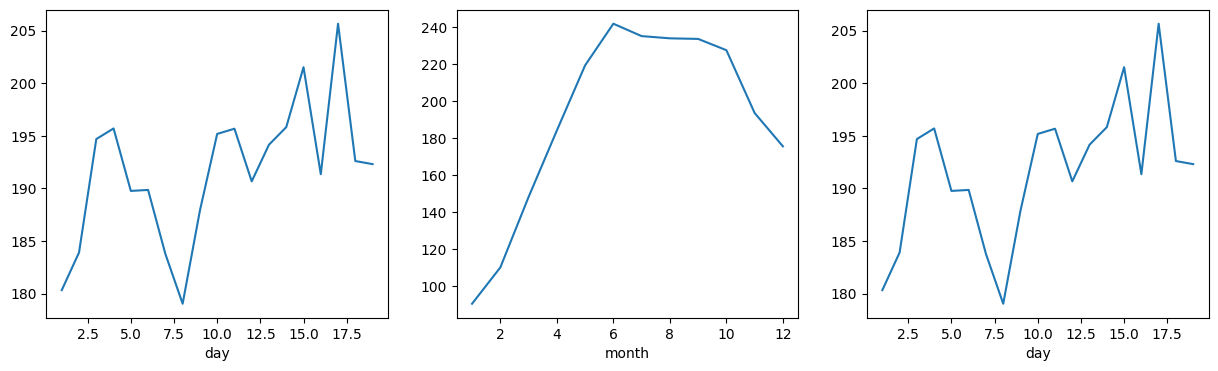

In [46]:
features = ['day', 'month', 'day']

plt.subplots(figsize = (15,4))
for i,col in enumerate(features):
  plt.subplot(1,3, i + 1)
  df.groupby(col).mean()['count'].plot()
plt.show()

**From the above line plots we can confirm some real-life observations:**

- There is no such pattern in the day-wise average of the ride requests.

- More ride requests in the working hours as compared to the non-working hours.

- The average ride request count has dropped in the month of festivals that is after the 7th month that is July that is due to more holidays in these months.

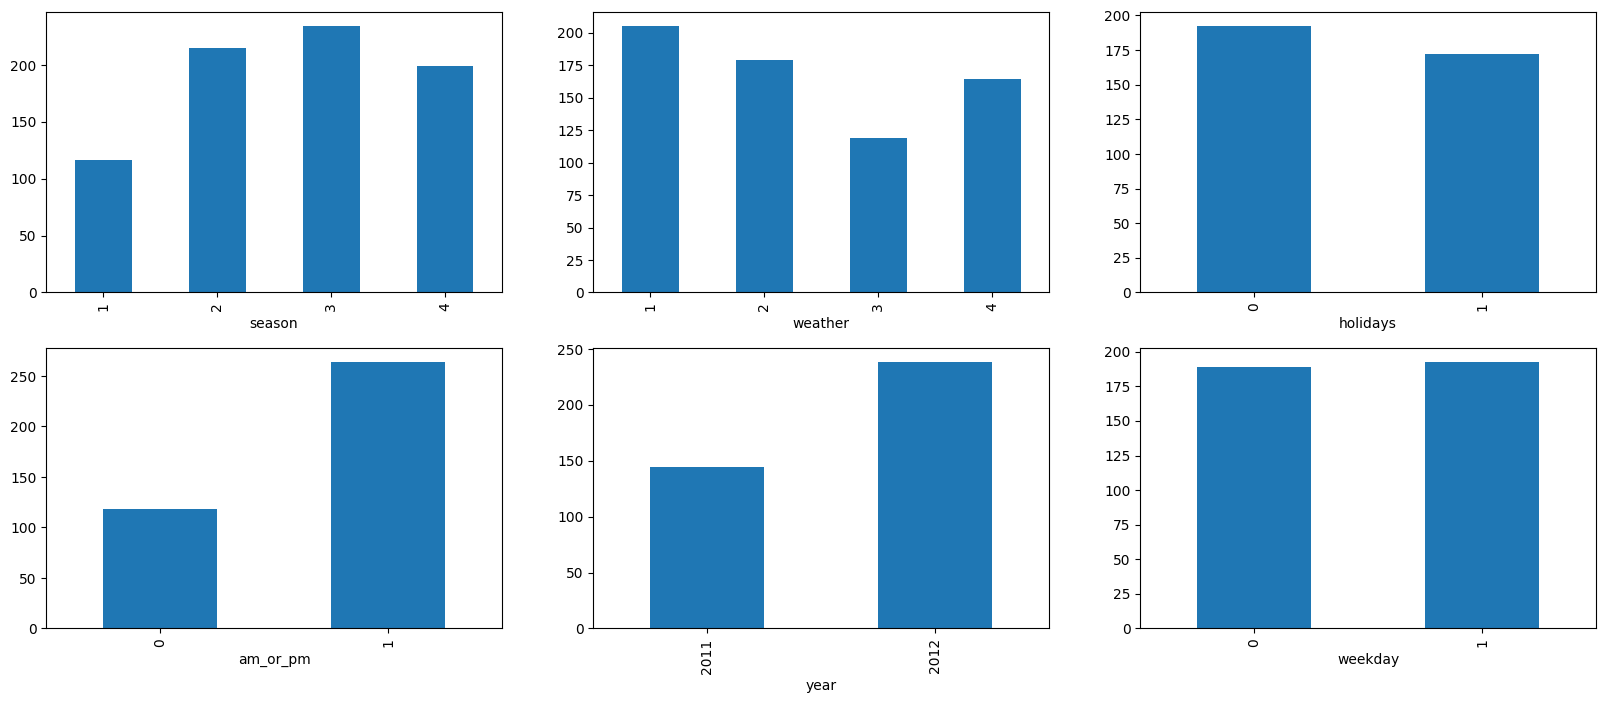

In [47]:
features = ['season', 'weather', 'holidays', \
            'am_or_pm','year','weekday']

plt.subplots(figsize = (20,8))
for i, col in enumerate(features):
  plt.subplot(2,3, i+1)
  df.groupby(col).mean()['count'].plot.bar()

plt.show()


**From the above bar plots we can confirm some real-life observations:**

- Ride request demand is high in the summer as well as season.
- The third category was extreme weather conditions due to this people avoid taking bike rides and like to stay safe at home.
- On holidays no college or offices are open due to this ride request demand is low.
- More ride requests during working hours as compared to non-working hours.
- Bike ride requests have increased significantly from the year 2011 to the year 2012.

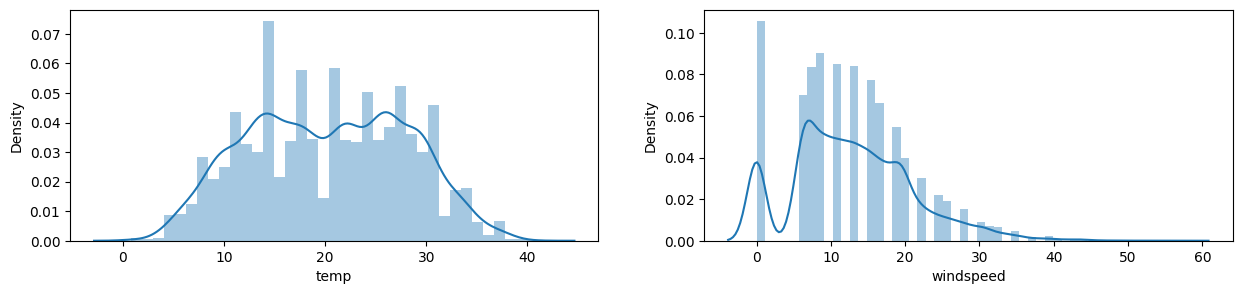

In [48]:
features = ['temp','windspeed']

plt.subplots(figsize = (15,3))
for i, col in enumerate(features):
  plt.subplot(1,2, i+1)
  sb.distplot(df[col])

plt.show()

Temperature values are normally distributed but due to the high number of 0 entries in the windspeed column, the data distribution shows some irregularities.

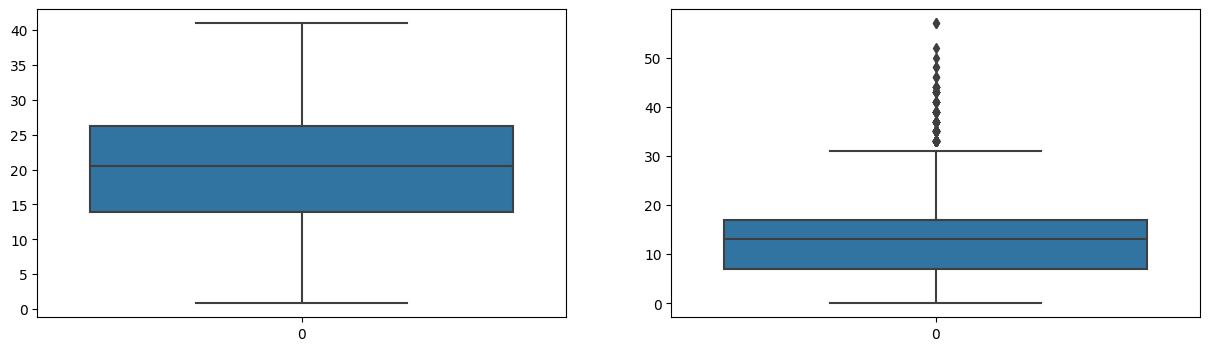

In [49]:
features = ['temp', 'windspeed']

plt.subplots(figsize = (15,4))
for i, col in enumerate(features):
  plt.subplot(1,2, i +1)
  sb.boxplot(df[col])

plt.show()

Ah! outliers let’s check how much data we will lose if we remove outliers.



In [50]:
num_rows = df.shape[0]- df[df['windspeed'] < 32].shape[0]
print(f'Number of rows that will be lost if we remove outliers is equal to  {num_rows}.')

Number of rows that will be lost if we remove outliers is equal to  227.


We can remove this many rows because we have around 10000 rows of data so, this much data loss won’t affect the learning for our model.

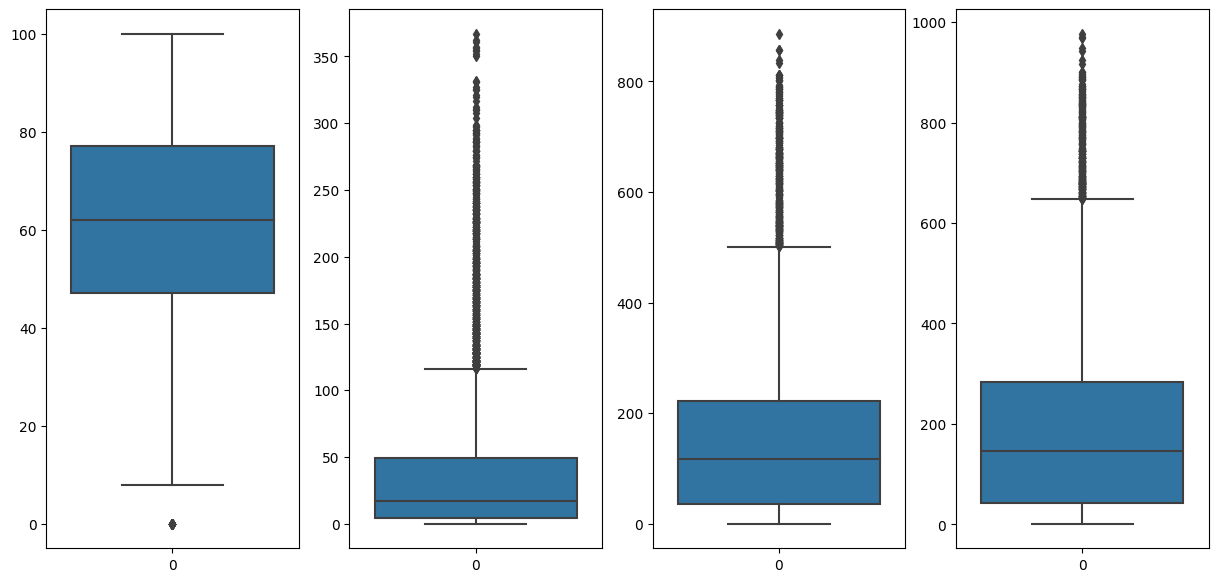

In [51]:
features = ['humidity', 'casual','registered', 'count']

plt.subplots(figsize = (15,7))
for i, col in enumerate(features):
  plt.subplot(1, 4, i+1)
  sb.boxplot(df[col])

plt.show()

Now let’s check whether there are any highly correlated features in our dataset or not. 

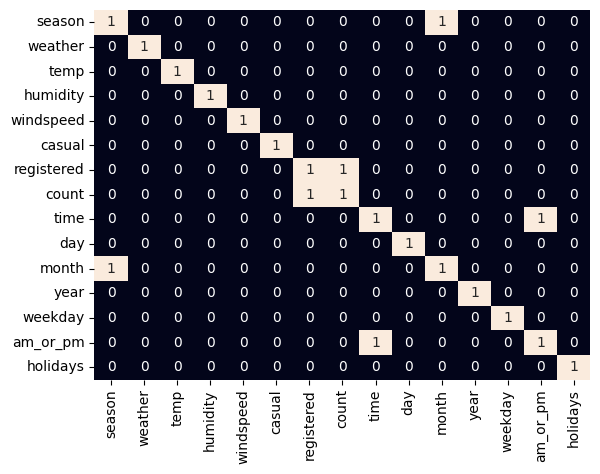

In [52]:
sb.heatmap(df.corr() > 0.8,
           annot = True,
           cbar = False)
plt.show()

Here the registered feature is highly correlated with our target variable which is count. 

This will lead to a situation of data leakage if we do not handle this situation. 

So, let’s remove this ‘registered’ column from our feature set and also the ‘time’ feature.

Now, we have to remove the outliers we found in the above two observations that are for the humidity and wind speed.

In [53]:
df.drop(['year'], axis = 1, inplace = True)
df = df[(df['windspeed'] < 32) & (df['humidity'] > 0)]

### **Model Training**

Now we will separate the features and target variables and split them into training and the testing data by using which we will select the model which is performing best on the validation data.

In [54]:
features = df.drop(['count'], axis = 1)
target = df['count'].values

print(features[-5:])
print(target[-5:])
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.2, random_state = 10)
X_train.shape, X_test.shape

       season  weather   temp  humidity  windspeed  casual  registered  time  \
10881       4        1  15.58        50    26.0027       7         329    19   
10882       4        1  14.76        57    15.0013      10         231    20   
10883       4        1  13.94        61    15.0013       4         164    21   
10884       4        1  13.94        61     6.0032      12         117    22   
10885       4        1  13.12        66     8.9981       4          84    23   

       day  month  weekday  am_or_pm  holidays  
10881   19     12        1         1         0  
10882   19     12        1         1         0  
10883   19     12        1         1         0  
10884   19     12        1         1         0  
10885   19     12        1         1         0  
[336 241 168 129  88]


((8510, 13), (2128, 13))

Normalizing the data before feeding it into machine learning models helps us to achieve stable and fast training.

We have split our data into training and validation data also the normalization of the data has been done. Now let’s train some state-of-the-art machine learning models and select the best out of them using the validation dataset.

In [55]:
from sklearn.metrics import mean_absolute_error as mae
models = [LinearRegression(), XGBRegressor(),RandomForestRegressor()]

for i in range(3):
  models[i].fit(X_train, Y_train)
  print(f'{models[i]} : ')

  train_pred = models[i].predict(X_train)
  print('Training error :' , mae(Y_train, train_pred))

  val_pred = models[i].predict(X_test)
  print('Validation error :' , mae(Y_test, val_pred))

LinearRegression() : 
Training error : 8.851283722156703e-14
Validation error : 9.00476435271772e-14
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...) : 
Training error : 0.9531729965456505
Validation error : 1.95036260346721
RandomForestRegressor() : 
Training error : 0.4976545240893067
Validation error : 1

The predictions made by the RandomForestRegressor are really amazing compared to the other model. In the case of RandomForestRegressor, there is a little bit of overfitting but we can manage it by hyperparameter tuning.

In [65]:
model = RandomForestRegressor()


model.fit(X_train, Y_train)


RandomForestRegressor()

In [66]:
import numpy 
accuracy = model.score(X_test,Y_test)
print("accuracy",accuracy)

accuracy 0.9997339231442861


In [67]:
# checking for overfitting and underfitting the data
print("Training set score: {:.4f}".format(model.score(X_train,Y_train)))
print("Testing score : {:.4f}".format(model.score(X_test,Y_test)))

Training set score: 0.9999
Testing score : 0.9997


In [68]:
def predict_count(season, weather, temp, humidity, windspeed, casual, registered,time,day, month, weekday, am_or_pm, holidays):    

    x = np.zeros(len(features.columns))
    x[0] = season
    x[1] = weather
    x[2] = temp
    x[3] = humidity
    x[4] = windspeed
    x[5] = casual
    x[6] = registered
    x[7] = time
    x[8] = day
    x[9] = month
    x[10] = weekday
    x[11] = am_or_pm
    x[12] = holidays 
    
    return model.predict([x])[0]

predict_count(4,1,13.12,66,8.9981,4,84,23,19,12,1,1,0)

87.98

In [69]:
import pickle
# open a file, where you want to store the data
file = open('ola.pkl', 'wb')
# dump information to that file
pickle.dump(model, file)
file.close()

In [70]:
import json
columns = {
    "data_columns" : [col.lower() for col in features.columns]
}
with open("columns.json", "w") as f:
  f.write(json.dumps(columns))


In [71]:
model = open("ola.pkl", 'rb')
forest = pickle.load(model)

In [72]:
y_pred = forest.predict(X_test)
metrics.r2_score(Y_test, y_pred)

0.9997339231442861